# DQN

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: /device:GPU:0


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
import numpy as np

state = env.reset()
batch = []
for _ in range(1000):
    # env.render()
    action = env.action_space.sample()
    next_state, reward, done, info = env.step(action) # take a random action
    batch.append([state, action, next_state, reward, float(done)])
    #     print('state, action, reward, done, info:', 
    #           state, action, reward, done, info)
    state = next_state
    if done:
        state = env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [4]:
batch[0], batch[0][0].shape

([array([-0.02627469, -0.00251987,  0.02072053, -0.03802255]),
  0,
  array([-0.02632508, -0.19793273,  0.01996008,  0.26112522]),
  1.0,
  0.0],
 (4,))

In [5]:
states = np.array([each[0] for each in batch])
actions = np.array([each[1] for each in batch])
next_states = np.array([each[2] for each in batch])
rewards = np.array([each[3] for each in batch])
dones = np.array([each[4] for each in batch])

In [6]:
print(rewards[-20:])
print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print(np.max(np.array(actions)), np.min(np.array(actions)))
print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print(np.max(np.array(rewards)), np.min(np.array(rewards)))
print(np.max(np.array(states)), np.min(np.array(states)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
(1000,) (1000, 4) (1000,) (1000,)
float64 float64 int64 float64
1 0
2
1.0 1.0
2.1975676927996597 -2.456453016737691


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [7]:
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    return states, actions, targetQs

In [8]:
# Generator: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [9]:
def model_loss(states, actions, targetQs, action_size, hidden_size):
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    Qs = tf.reduce_max(actions_logits*actions_labels, axis=1)
    #Qs = tf.reduce_max(actions_logits, axis=1)
    loss = tf.reduce_mean(tf.square(Qs - targetQs))
    return actions_logits, loss

In [10]:
def model_opt(loss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        opt = tf.train.AdamOptimizer(learning_rate).minimize(loss, var_list=g_vars)

    return opt

In [11]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.loss = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, targetQs=self.targetQs) # model input

        # Update the model: backward pass and backprop
        self.opt = model_opt(loss=self.loss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [12]:
# from collections import deque
# class Memory():
#     def __init__(self, max_size = 1000):
#         self.buffer = deque(maxlen=max_size) # data batch
#         self.rates = deque(maxlen=max_size) # rates
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx], [self.rates[ii] for ii in idx]

In [16]:
def sample(batch_size, ListArr):
    idx = np.random.choice(np.arange(len(ListArr)), 
                           size=batch_size, 
                           replace=True)
    return [ListArr[ii] for ii in idx]

In [17]:
# sample(batch_size=10, arr_length=100)

In [19]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
#     def sample(self, batch_size):
#         idx = np.random.choice(np.arange(len(self.buffer)), 
#                                size=batch_size, 
#                                replace=False)
#         return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [20]:
env.observation_space, env.action_space

(Box(4,), Discrete(2))

In [73]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01           # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
state_size = 4
action_size = 2
hidden_size = 24*2             # number of units in each Q-network hidden layer
learning_rate = 1e-4         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = int(1e2)             # experience mini-batch size
gamma = 0.99                   # future reward discount

In [74]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)
# memory2 = Memory(max_size=memory_size)

## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [75]:
# Initializing the memory with the pool of random exploration of the env.
state = env.reset() # env-based
total_reward = 0 # episode R
num_step = 0 # episode steps/ length based on number of steps
goal = 500 # env-based, the total reward required for reaching the goal G
for _ in range(memory_size):
    action = env.action_space.sample() # exploring the env action space/ random action/ explore
    next_state, reward, done, _ = env.step(action) # exploring the env state, reward, and done/end
    #memory.buffer[idxxx][FIRST, 111111, 2222222222, 333333, 4444444444, LAST]
    #memory.buffer[idxxx][00000, 111111, 2222222222, 333333, 4444444444, 5555]
    memory.buffer.append([state, action, next_state, reward, float(done), -1])
    num_step += 1 # memory incremented
    total_reward += reward # R += r
    state = next_state # update the state for next episode
    # At the end of episode, rate the played episode and prepared for the next episode
    if done is True: # end of this episode
        state = env.reset() # reset for next episode
        rate = total_reward/goal # the actual sucess rate of the played sequence
        total_reward = 0 # reset for next episode
        # Rating the played sequence: success rating the played sequence
        # 0, 1, 2, .............................., num_steps-1
        for idx in range(num_step): # episode length
            # if memory.buffer[-1-idx][-1] == -1: # double-check if it is empty and it is not rated!
            #     memory.buffer[-1-idx][-1] = rate # rate each SA pair
            if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                memory.buffer[-1-idx][5] = rate # rate each SA pair
        num_step = 0 # reset for the next episode

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [ ]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(1111):
        total_reward = 0
        loss_batch = []
        state = env.reset()
        num_step = 0 # each episode

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step) 
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action_logits = sess.run(model.actions_logits, feed_dict={model.states: state.reshape([1, -1])})
                action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            memory.buffer.append([state, action, next_state, reward, float(done), -1])
            num_step += 1 # momory added
            total_reward += reward
            state = next_state

            # Rating the memory
            if done is True:
                rate = total_reward/ goal # update rate at the end/ when episode is done
                for idx in range(num_step): # episode length
                    if memory.buffer[-1-idx][5] == -1: # double-check if it is empty and it is not rated!
                        memory.buffer[-1-idx][5] = rate # rate each SA pair

            #sortedmemory = sorted(memory.buffer, key=lambda col:col[-1], reverse=True) # every episode
            sortedmemory = sorted(memory.buffer, key=lambda col:col[5], reverse=True) # every episode
            #ratedmemlength = len(sortedmemory)//2 # max rated half
            ratedbatch = [sortedmemory[idx] for idx in range(len(sortedmemory)//2)]
            batch = sample(batch_size=batch_size, ListArr=ratedbatch)
            states = np.array([each[0] for each in batch])#[idx*batch_size:(idx+1)*batch_size]
            actions = np.array([each[1] for each in batch])#[idx*batch_size:(idx+1)*batch_size]
            next_states = np.array([each[2] for each in batch])#[idx*batch_size:(idx+1)*batch_size]
            rewards = np.array([each[3] for each in batch])#[idx*batch_size:(idx+1)*batch_size]
            dones = np.array([each[4] for each in batch])#[idx*batch_size:(idx+1)*batch_size]
            rates = np.array([each[5] for each in batch])#[idx*batch_size:(idx+1)*batch_size] # the fifth one
            #nextQs_logits = sess.run(model.Qs_logits, feed_dict = {model.states: next_states})
            next_actions_logits = sess.run(model.actions_logits, feed_dict = {model.states: next_states})
            nextQs = np.max(next_actions_logits, axis=1) * (1-dones)
            targetQs = rewards + (gamma * nextQs)
            loss, _ = sess.run([model.loss, model.opt], feed_dict = {model.states: states, 
                                                                     model.actions: actions,
                                                                     model.targetQs: targetQs})
            loss_batch.append(loss)
            if done is True:
                break
                
        episode_reward.append(total_reward)
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'rate:{:.4f}'.format(rate),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:35.0000 R:35.0 rate:0.0700 loss:1.0638 exploreP:0.9965
Episode:1 meanR:23.0000 R:11.0 rate:0.0220 loss:1.1078 exploreP:0.9955
Episode:2 meanR:23.0000 R:23.0 rate:0.0460 loss:1.1465 exploreP:0.9932
Episode:3 meanR:21.2500 R:16.0 rate:0.0320 loss:1.1820 exploreP:0.9916
Episode:4 meanR:19.6000 R:13.0 rate:0.0260 loss:1.2248 exploreP:0.9903
Episode:5 meanR:18.6667 R:14.0 rate:0.0280 loss:1.2418 exploreP:0.9890
Episode:6 meanR:20.2857 R:30.0 rate:0.0600 loss:1.2974 exploreP:0.9860
Episode:7 meanR:19.6250 R:15.0 rate:0.0300 loss:1.3933 exploreP:0.9846
Episode:8 meanR:19.2222 R:16.0 rate:0.0320 loss:1.3763 exploreP:0.9830
Episode:9 meanR:20.6000 R:33.0 rate:0.0660 loss:1.3495 exploreP:0.9798
Episode:10 meanR:21.0909 R:26.0 rate:0.0520 loss:1.2959 exploreP:0.9773
Episode:11 meanR:20.8333 R:18.0 rate:0.0360 loss:1.2771 exploreP:0.9756
Episode:12 meanR:20.6154 R:18.0 rate:0.0360 loss:1.2438 exploreP:0.9738
Episode:13 meanR:20.3571 R:17.0 rate:0.0340 loss:1.2688 exploreP:0.9722
Ep

Episode:113 meanR:18.5500 R:25.0 rate:0.0500 loss:70.8447 exploreP:0.8093
Episode:114 meanR:18.5200 R:15.0 rate:0.0300 loss:51.1485 exploreP:0.8081
Episode:115 meanR:18.3300 R:16.0 rate:0.0320 loss:67.3481 exploreP:0.8068
Episode:116 meanR:18.4200 R:24.0 rate:0.0480 loss:65.9991 exploreP:0.8049
Episode:117 meanR:18.4400 R:11.0 rate:0.0220 loss:57.0044 exploreP:0.8040
Episode:118 meanR:18.4600 R:15.0 rate:0.0300 loss:64.2328 exploreP:0.8028
Episode:119 meanR:18.6700 R:46.0 rate:0.0920 loss:57.2678 exploreP:0.7992
Episode:120 meanR:18.7400 R:26.0 rate:0.0520 loss:51.0270 exploreP:0.7971
Episode:121 meanR:18.9000 R:33.0 rate:0.0660 loss:59.9051 exploreP:0.7945
Episode:122 meanR:18.7400 R:17.0 rate:0.0340 loss:56.0064 exploreP:0.7932
Episode:123 meanR:18.8200 R:21.0 rate:0.0420 loss:39.3432 exploreP:0.7916
Episode:124 meanR:18.7800 R:9.0 rate:0.0180 loss:56.1961 exploreP:0.7909
Episode:125 meanR:18.7600 R:9.0 rate:0.0180 loss:31.8512 exploreP:0.7902
Episode:126 meanR:18.5700 R:14.0 rate:0.

Episode:224 meanR:41.7000 R:91.0 rate:0.1820 loss:46.6732 exploreP:0.5246
Episode:225 meanR:41.8100 R:20.0 rate:0.0400 loss:56.3057 exploreP:0.5236
Episode:226 meanR:42.1700 R:50.0 rate:0.1000 loss:48.6598 exploreP:0.5210
Episode:227 meanR:42.6300 R:64.0 rate:0.1280 loss:51.2460 exploreP:0.5178
Episode:228 meanR:42.6500 R:17.0 rate:0.0340 loss:47.2194 exploreP:0.5169
Episode:229 meanR:42.5200 R:21.0 rate:0.0420 loss:48.2316 exploreP:0.5158
Episode:230 meanR:42.5200 R:37.0 rate:0.0740 loss:34.7900 exploreP:0.5140
Episode:231 meanR:43.6100 R:119.0 rate:0.2380 loss:57.9396 exploreP:0.5080
Episode:232 meanR:44.8300 R:137.0 rate:0.2740 loss:51.8155 exploreP:0.5012
Episode:233 meanR:44.3000 R:23.0 rate:0.0460 loss:58.5103 exploreP:0.5001
Episode:234 meanR:44.4300 R:43.0 rate:0.0860 loss:52.6248 exploreP:0.4980
Episode:235 meanR:44.6800 R:34.0 rate:0.0680 loss:54.3524 exploreP:0.4963
Episode:236 meanR:45.2300 R:92.0 rate:0.1840 loss:53.1350 exploreP:0.4919
Episode:237 meanR:45.6500 R:77.0 rat

Episode:333 meanR:169.1600 R:324.0 rate:0.6480 loss:353.4045 exploreP:0.1003
Episode:334 meanR:173.0000 R:427.0 rate:0.8540 loss:379.3970 exploreP:0.0965
Episode:335 meanR:177.2200 R:456.0 rate:0.9120 loss:370.5241 exploreP:0.0927
Episode:336 meanR:180.0000 R:370.0 rate:0.7400 loss:369.4720 exploreP:0.0897
Episode:337 meanR:183.9200 R:469.0 rate:0.9380 loss:409.1259 exploreP:0.0860
Episode:338 meanR:186.3700 R:288.0 rate:0.5760 loss:418.8850 exploreP:0.0838
Episode:339 meanR:191.0800 R:500.0 rate:1.0000 loss:396.0710 exploreP:0.0802
Episode:340 meanR:193.3500 R:285.0 rate:0.5700 loss:388.8001 exploreP:0.0783
Episode:341 meanR:196.6100 R:373.0 rate:0.7460 loss:410.9783 exploreP:0.0758
Episode:342 meanR:200.9000 R:500.0 rate:1.0000 loss:404.9829 exploreP:0.0726
Episode:343 meanR:205.5300 R:500.0 rate:1.0000 loss:413.1300 exploreP:0.0695
Episode:344 meanR:209.1400 R:374.0 rate:0.7480 loss:420.5176 exploreP:0.0673
Episode:345 meanR:213.6600 R:500.0 rate:1.0000 loss:426.9481 exploreP:0.0645

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [202]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

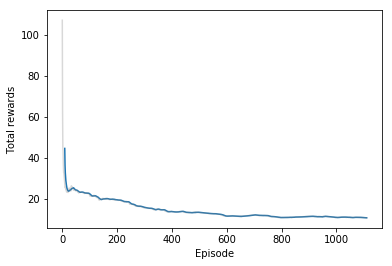

In [203]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

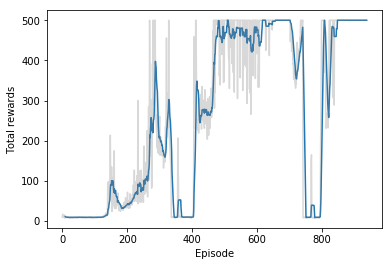

In [24]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Average losses')

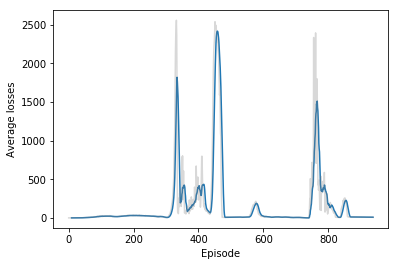

In [25]:
eps, arr = np.array(loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Average losses')

## Testing

Let's checkout how our trained agent plays the game.

In [24]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))
# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.